# Setting up environment

In [ ]:
!mkdir val2017
!gsutil -m rsync gs://images.cocodataset.org/val2017 val2017

In [ ]:
!mkdir coco
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip -d coco

In [ ]:
# !pip install tensorflow-gpu==2.0 lime
!pip install lime
!pip install -U setuptools
!pip install -U wheel
!make install -C cocoapi/PythonAPI # NOT WORKING

In [ ]:
!mkdir figures

In [1]:
import requests as r
from io import BytesIO
from math import floor
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.applications import inception_v3 as inc_net
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

1.13.1


Using TensorFlow backend.


In [2]:
inet_model = inc_net.InceptionV3()
explainer = lime_image.LimeImageExplainer()
root = ET.fromstring(r.get("http://www.image-net.org/api/xml/structure_released.xml").text)
imagenet_classes = eval(r.get("https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json").text)

Instructions for updating:
Colocations handled automatically by placer.


# Explanator wrapper

In [3]:
class explanator:
  def __init__(self, inet_model=None, explainer=None, root=None, class_mapping=None, imagenet_classes=None):

    self.inet_model = inet_model if inet_model else inc_net.InceptionV3()
    self.explainer = explainer if explainer else lime_image.LimeImageExplainer()
    self.root = root if root else ET.fromstring(r.get("http://www.image-net.org/api/xml/structure_released.xml").text)
    self.imagenet_classes = imagenet_classes if imagenet_classes else eval(r.get("https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json").text)
    
    if class_mapping:
      self.class_mapping = class_mapping
    else:
      self.class_mapping = {
          "person": {
              "wnid": "n00007846",
          },
          "bicycle": {
              "wnid": "n02834778"
          },
          "car": {
              "wnid": "n02958343"
          },
          "cat": {
              "wnid": "n02121808"
          }
      }

    self.wnid_mapping = {}
    self.fetch_mappings()

  def get_synset(self, wnid):
    for i in self.root[1].iter("synset"):
      if i.get("wnid") == wnid:
        return i

  def fetch_mappings(self):
    for i, v in self.class_mapping.items():
      # load sub_wnids
      synset = self.get_synset(v["wnid"])
      self.class_mapping[i]["sub_wnids"] = self.get_sub_wnids(synset)
      #load wnid_mapping
      for wnid in self.class_mapping[i]["sub_wnids"]+[v["wnid"]]:
        self.wnid_mapping[wnid] = i

  def download_and_preprocess(self, url):
    response = r.get(url)
    im = Image.open(BytesIO(response.content))
    im = im.resize((299, 299))
    x = image.img_to_array(im)
    x = np.expand_dims(x, axis=0)
    x = inc_net.preprocess_input(x)
    return im, x

  def predict(self, x):
    preds = self.inet_model.predict(x)
    preds_decoded = decode_predictions(preds)[0]
    return preds_decoded

  def get_segmentation(self, anns, img_md):
    scaler_v = np.vectorize(self.scaler, excluded=["S", "cx"])
    
    polygons = []
    segs = []
    color = []
    c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
    
    for seg in anns[0]["segmentation"]:
      poly, rescaled_seg = self.rescale_poly(seg, scaler_v, img_md["width"], img_md["height"])
      polygons.append(poly)  
      segs.append(rescaled_seg)
      color.append(c)
    return color, polygons, segs

  def explain(self, img, img_md, segmentation_fns, top_labels=5, num_samples=1000):
    annIds = coco.getAnnIds(imgIds=img_md['id'], catIds=[], iscrowd=None)
    anns = coco.loadAnns(annIds)
    color, polygons, segs = self.get_segmentation(anns, img_md)

    for segmentation_fn in segmentation_fns:
      explanation = self.explainer.explain_instance(img, self.inet_model.predict, top_labels=top_labels, hide_color=0, num_samples=num_samples, segmentation_fn=SegmentationAlgorithm(segmentation_fn))
      
      for i in explanation.top_labels:
        temp, mask = explanation.get_image_and_mask(i, positive_only=True, hide_rest=True)
        
        img_new = Image.new('L', mask.shape, 0)
        ImageDraw.Draw(img_new).polygon(segs[0].tolist()[0], outline=1, fill=1)
        poly_mask = np.array(img_new)
        
        iou = self.compute_iou(mask, poly_mask)
        print(f"IOU: {iou}")

        # to-do: Subplots
        self.plot_and_save_segmentation(img, mask, polygons, color, segmentation_fn, self.imagenet_classes[str(i)])

  def plot_and_save_segmentation(self, img, mask, polygons, color, segmentation_fn, classes):
    plt.figure(figsize=(10,10))
    plt.imshow(mark_boundaries(img / 2 + 0.5, mask))
    plt.title(segmentation_fn + " / " + str(classes))

    ax = plt.gca()
    p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)
    plt.axis('off')
    plt.show()

    plt.savefig("figures/" + segmentation_fn + "_" + classes[1] + ".png")
    
  @staticmethod
  def scaler(x, S, cx):
    return (  S * (x - cx) ) + cx

  @staticmethod
  def rescale_poly(poly, scaler_v, width, height):
    # poly: [x1,y1,x2,y2,...]
    n = len(poly)
    poly = np.array(poly).reshape((int(n/2), 2))
    poly[:,0] = scaler_v(poly[:,0], S=299/width, cx=0)
    poly[:,1] = scaler_v(poly[:,1], S=299/height, cx=0)
    return Polygon(poly), poly.reshape(1, n)

  @staticmethod
  def compute_iou(mask1, mask2): # to-do: bug: long -> u_int_8
    # alternatives: https://gist.github.com/meetshah1995/6a5ad112559ef1536d0191f8b9fe8d1e
    # https://www.jeremyjordan.me/evaluating-image-segmentation-models/
    
    # patch -> asfortranarray: https://github.com/cocodataset/cocoapi/issues/91
    enc_mask1 = coco_mask.encode(np.asfortranarray(mask1))
    enc_mask2 = coco_mask.encode(np.asfortranarray(mask2))
    
    iou = coco_mask.iou(enc_mask1, enc_mask2, 0)
    return iou

  @staticmethod
  def get_sub_wnids(synset):
    sub_wnids = []
    for i in synset.iter("synset"):
      sub_wnids.append(i.get("wnid"))
    return sub_wnids

  @staticmethod
  def plot_segmentations(img, segmentation_fns):
    n_cols = 2
    n_rows = floor(len(segmentation_fns) / n_cols)
    if len(segmentation_fns) % n_cols > 0:
      n_rows += 1

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 10), sharex=True, sharey=True)
    cnt = -1

    for segmentation_fn, params in segmentation_fns.items():
      cnt += 1

      # eval segmentation
      img_param = img if segmentation_fn != 'watershed' else sobel(rgb2gray(img))
      str_params = ', '.join([f"{k}={v}" for k,v in params.items()])
      function = segmentation_fn + '(img_param, ' + str_params + ')'
      print(function)
      segments = eval(function)
      print(f"{segmentation_fn} number of segments: {len(np.unique(segments))}")

      # plot
      r = floor(cnt / n_cols)
      c = cnt % n_cols
      ax[r, c].imshow(mark_boundaries(img, segments))
      ax[r, c].set_title(segmentation_fn)

    for a in ax.ravel():
        a.set_axis_off()

    plt.tight_layout()
    plt.show()

# COCO


In [4]:
%matplotlib inline
from pycocotools.coco import COCO
import pycocotools.mask as coco_mask
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [5]:
dataDir='coco'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


# Test

In [6]:
# explanator
model = explanator(inet_model=inet_model, explainer=explainer, root=root, imagenet_classes=imagenet_classes)

# images
# im, x = model.download_and_preprocess("http://farm7.staticflickr.com/6012/5930972911_f491d3f29a_z.jpg")
# im, x = model.download_and_preprocess("http://farm1.staticflickr.com/14/88446581_f02412ae00_z.jpg")
# im, x = model.download_and_preprocess("http://images.cocodataset.org/val2017/000000106389.jpg")
# plt.figure(figsize=(10, 10))
# plt.imshow(im)

In [7]:
# coco images
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
furniture indoor accessory electronic kitchen sports appliance animal food outdoor person vehicle


In [8]:
catIds = coco.getCatIds(catNms=['cat']);
imgIds = coco.getImgIds(catIds=catIds);
print(f"Coco images: {len(imgIds)}")

Coco images: 184


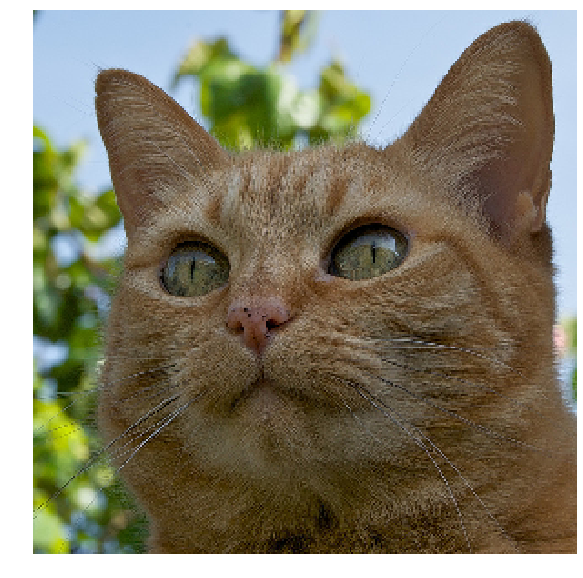

In [9]:
# easy example 524280
imgIds = coco.getImgIds(imgIds = [524280])
img_md = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
# img_md = coco.loadImgs(imgIds)

im, x = model.download_and_preprocess(img_md['coco_url'])

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(im)

### Segmentation

quickshift(img_param, kernel_size=4, max_dist=200, ratio=0.2)
quickshift number of segments: 59
felzenszwalb(img_param, scale=100, sigma=2, min_size=50)
felzenszwalb number of segments: 97
slic(img_param, )
slic number of segments: 68
watershed(img_param, markers=250, compactness=0.001)
watershed number of segments: 256


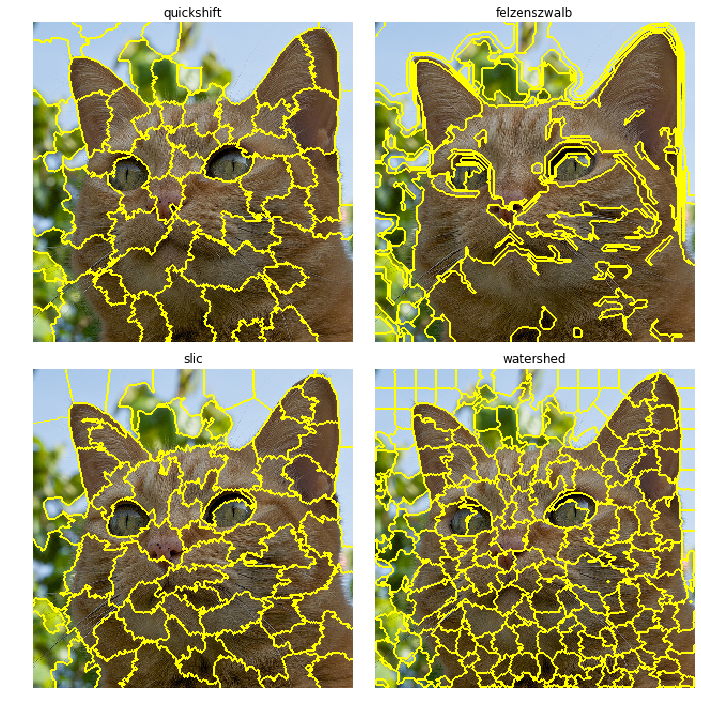

In [10]:
# to-do: future refactoring -> add parameters to segmentation_fns dictionary. Check plot_segmentations method.
segmentation_fns = {
  'quickshift': {
      'kernel_size': 4,
      'max_dist': 200,
      'ratio': 0.2
  }, 
  'felzenszwalb': {
      'scale': 100,
      'sigma': 2,
      'min_size': 50,
  },
  'slic': {
      #  'n_segments': 250,
      #  'compactness': 10,
      #  'sigma': 1
  },
  'watershed': {
      'markers': 250,
      'compactness': 0.001
  }
}

model.plot_segmentations([np.array(im)][0], segmentation_fns)

### Predictions

In [11]:
model.predict(x)

[('n02123045', 'tabby', 0.50437176),
 ('n02123159', 'tiger_cat', 0.21029814),
 ('n02123394', 'Persian_cat', 0.079715386),
 ('n02124075', 'Egyptian_cat', 0.034732353),
 ('n02127052', 'lynx', 0.01936864)]

### Explanations

In [12]:
# drop watershed for this test
segmentation_fns = {
  'quickshift': {
      'kernel_size': 4,
      'max_dist': 200,
      'ratio': 0.2
  }, 
  'felzenszwalb': {
      'scale': 100,
      'sigma': 2,
      'min_size': 50,
  },
  'slic': {
      #  'n_segments': 250,
      #  'compactness': 10,
      #  'sigma': 1
  },
  # 'watershed': {
  #     'markers': 250,
  #     'compactness': 0.001
  # }
}
model.explain(x[0], img_md, segmentation_fns)

100% |########################################################################|


ValueError: Buffer dtype mismatch, expected 'uint8_t' but got 'long long'